TODO:
1) EDA
2) Run some training script (ready opensource solution)
3) Analyse results (confusion matrix, some exact cases)

In [1]:
!pip install -U transformers==4.46.3 evaluate==0.4.6 seqeval==1.2.2 datasets==3.1.0 transformers==4.46.3 torch torcheval torchmetrics torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 148.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 153.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.3 MB/s eta 0:00:00
   

In [5]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BatchEncoding,
    set_seed,
)
import torch
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import os

os.environ["WANDB_DISABLED"] = "false"
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [7]:
!echo $CUDA_VISIBLE_DEVICES

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Фиксация всех RNG для воспроизводимости:

In [9]:
def set_all_seeds(seed: int):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = (
        True  # Ensure deterministic computation in cuDNN
    )
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN auto-tuner for reproducibility
    )
    set_seed(seed)  # Hugging Face transformers seed setting


set_all_seeds(1337)

В качестве данных для работы был выбран датасет `Conll2012`

In [10]:
ds = load_dataset("ramybaly/conll2012")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


conll2012.py: 0.00B [00:00, ?B/s]

conll2012/train/0000.parquet:   0%|          | 0.00/9.70M [00:00<?, ?B/s]

conll2012/validation/0000.parquet:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

conll2012/test/0000.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/115812 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12217 [00:00<?, ? examples/s]

Зарегистрируем дополнительны метаданные о разметке для анализа в будущем (маппинг не поставляется с самим датасето, взят из страницы датасета):

In [11]:
LABEL_NAMES = [
    "O",
    "B-CARDINAL",  # количиственные числительные: three, 200, one million, ...
    "B-DATE",  # даты
    "B-EVENT",  # события: Olympic games, Easter, ...
    "B-FAC",  # сооружения (facilities): Eiffel Tower, JFK airport, ...
    "B-GPE",  # геополитические образования: New York, Texas, ...
    "B-LANGUAGE",  # языки: English, French, ...
    "B-LAW",  # законы и нормативные акты: Constitution, Civil Rights Act, ...
    "B-LOC",  # географические локации: Mount Everest, Nile River, ...
    "B-MONEY",  # денежные выражения: $5, 10 euros, five million rubles
    "B-NORP",  # национальности, религии, политические группы: Russians, Buddhists, Republicans, ...
    "B-ORDINAL",  # порядковые числительные: first, second, third, ...
    "B-ORG",  # организации: Google, United Nations, ...
    "B-PERCENT",  # проценты: 50%, twenty percent
    "B-PERSON",  # имена людей: David Lynch, Maxim Kats, ...
    "B-PRODUCT",  # продукты и бренды: Coca-Cola, Iphone, ...
    "B-QUANTITY",  # измеряемые величины с единицами: 5kg, 10 meters, ...
    "B-TIME",  # время: 2 a.m., morning, ...
    "B-WORK_OF_ART",  # произведения искусства: Mona Lisa, Воронины, ...
    "I-CARDINAL",
    "I-DATE",
    "I-EVENT",
    "I-FAC",
    "I-GPE",
    "I-LANGUAGE",
    "I-LAW",
    "I-LOC",
    "I-MONEY",
    "I-NORP",
    "I-ORDINAL",
    "I-ORG",
    "I-PERCENT",
    "I-PERSON",
    "I-PRODUCT",
    "I-QUANTITY",
    "I-TIME",
    "I-WORK_OF_ART",
]

ENTITY_MAPPING = {i: ent for i, ent in enumerate(LABEL_NAMES)}

In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 12217
    })
})

In [13]:
ds_train = ds["train"].remove_columns(["id", "pos_tags"])
ds_val = ds["validation"].remove_columns(["id", "pos_tags"])
ds_test = ds["test"].remove_columns(["id", "pos_tags"])

df_train = ds_train.to_pandas()
df_val = ds_val.to_pandas()
df_test = ds_test.to_pandas()

Датасет

In [14]:
df_train

,tokens,tags
0,"[Big, Managers, on, Campus]","[0, 0, 0, 0]"
1,"[In, recent, years, ,, advanced, education, fo...","[0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[With, this, trend, ,, suddenly, the, mature, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[In, order, to, attract, this, group, of, seas...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 27..."
4,"[In, response, ,, each, year, over, 1000, matu...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
115807,"[In, fact, ,, Iraq, has, almost, sunk, into, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115808,"[The, same, day, ,, the, US, National, Broadca...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115809,"[Analysts, here, have, pointed, out, that, Ann...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115810,"[Calls, from, within, the, US, for, the, withd...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
classes_cnt = {}
for tag_arr in tqdm(df_train["tags"]):
    for cls_num in tag_arr:
        cls_name = ENTITY_MAPPING[cls_num]
        if cls_name != "O":
            cls_name = cls_name[2:]
        if cls_name not in classes_cnt:
            classes_cnt[cls_name] = 1
        else:
            classes_cnt[cls_name] += 1

100%|██████████| 115812/115812 [00:04<00:00, 27146.36it/s]


Text(0.5, 1.0, 'Token classes distribution in train dataset')

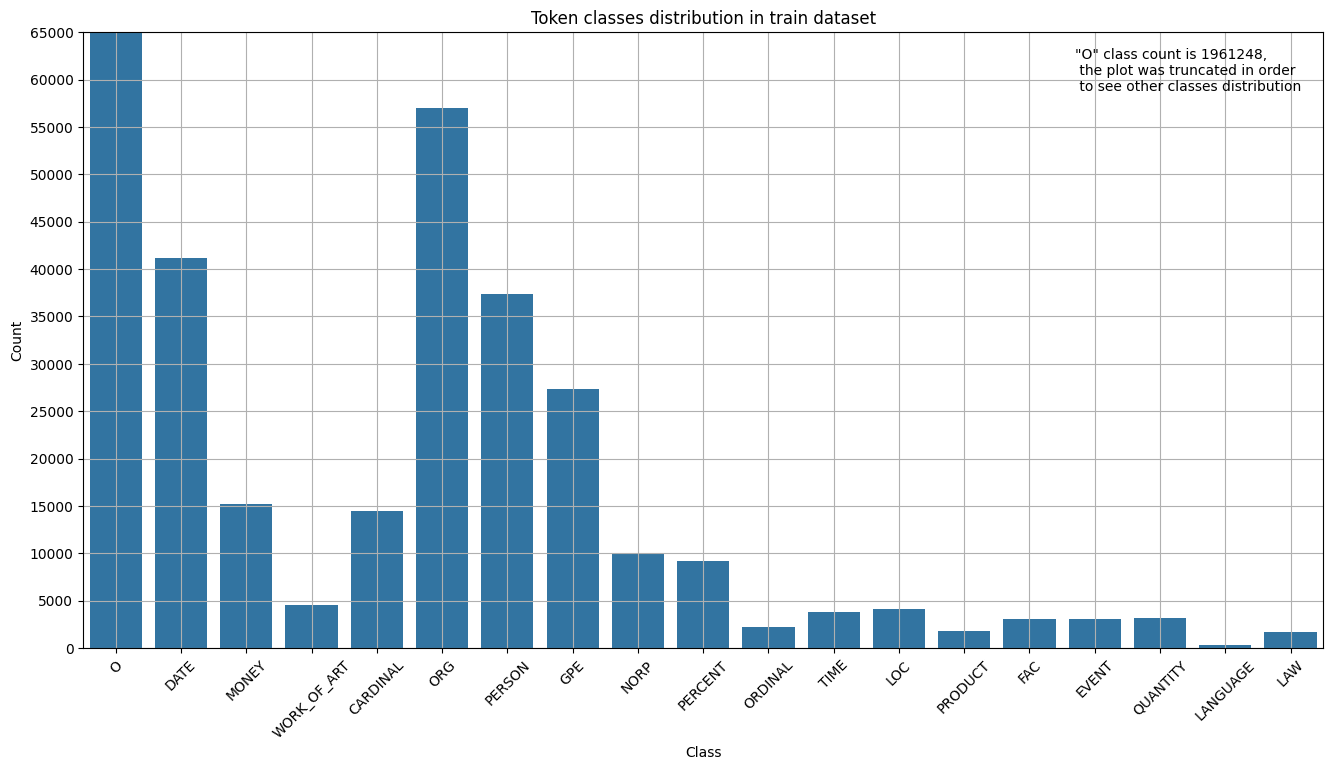

In [16]:
df = pd.DataFrame(list(classes_cnt.items()), columns=["Class", "Count"])

# Create the bar plot using Seaborn
plt.figure(figsize=(16, 8))  # Optional: Adjust figure size
sns.barplot(x="Class", y="Count", data=df)
plt.yticks(np.arange(0, max(df["Count"]) + 1, 5000))
plt.ylim((0, 0.065 * 1e6))
plt.xticks(rotation=45)
plt.text(
    0.80,
    0.90,
    f'"O" class count is {classes_cnt["O"]},\n the plot was truncated in order\n to see other classes distribution',
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="black",
)
plt.grid(True)

# Add a title to the plot
plt.title("Token classes distribution in train dataset")

In [17]:
idx = 116
dict(
    zip(
        df_train.iloc[idx]["tokens"],
        [ENTITY_MAPPING[klass] for klass in df_train.iloc[idx]["tags"]],
    )
)

{'Last': 'B-DATE',
 'year': 'I-DATE',
 ',': 'O',
 'one': 'B-CARDINAL',
 'professor': 'O',
 'made': 'O',
 'a': 'O',
 'big': 'O',
 'hit': 'O',
 'with': 'O',
 'over': 'O',
 '30': 'B-CARDINAL',
 'students': 'O',
 'taking': 'O',
 'them': 'O',
 'to': 'O',
 'mainland': 'O',
 'China': 'B-GPE',
 'for': 'O',
 'ten': 'B-DATE',
 'days': 'I-DATE',
 'familiarize': 'O',
 'the': 'O',
 'investment': 'O',
 'environment': 'O',
 'there': 'O',
 '.': 'O'}

In [18]:
seq_lens = []
for tok_arr in tqdm(df_train["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Train set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_val["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Validation set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_test["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Test set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}"
)

100%|██████████| 115812/115812 [00:00<00:00, 1224963.58it/s]


Train set:
Min sentance length: 1.00
Avg sentance length: 19.00
Max sentance length: 228.00



100%|██████████| 15680/15680 [00:00<00:00, 1203526.15it/s]


Validation set:
Min sentance length: 1.00
Avg sentance length: 19.43
Max sentance length: 275.00



100%|██████████| 12217/12217 [00:00<00:00, 1211390.35it/s]

Test set:
Min sentance length: 1.00
Avg sentance length: 18.84
Max sentance length: 151.00


In [19]:
# TODO distro plot for lengths

### Модель


Для задачи подходит декодерная модель BERT с двунаправленным attention-механизмом.
![image.png](./_img/BERT.png)
В пайплайне применяется предобученная модель BERT, self-supervised задача на претренировке состоит из 2 частей - $MLM^1$ и $NSP^2$:


1. 15% процентов токенов маскируются, то есть заменяются на [MASK]
2. Бинарный обджектив-индиктор, являются для заколлейченых в 1 сэмпл преложения реально последовательно встречающимися в тексте.

NER-задача сводится к классификации каждого токена, что означает, что больше подходит дискриминативная модель, ей и является BERT; специфика NER задачи также требует cased-токенизации, так как потенциально поможет в некоторых случаях определить собственные имена.

EDA датасета показывает оценку длины в словах, BPE, как subword метод, увеличивает длину после токенизации; распространенной оценкой является $|text|_{words}\approx 0.75 \times |text|_{BPE-tokens}$

Так как максимальное количество слов в датасете 228, для того, чтобы все токены точно были обработаны требуется $\lceil228/0.75\rceil = 304$, длины принято брать степенями двойки, соответственно нужна модель с $2^{\lceil\log_2 304\rceil} = 2^9 = 512$ токенов.

In [20]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 512
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

In [21]:
ds_full = dataset = DatasetDict(
    {"train": ds_train, "validation": ds_val, "test": ds_test}
)

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [23]:
label2id = {label: i for i, label in enumerate(LABEL_NAMES)}
id2label = {i: label for i, label in enumerate(LABEL_NAMES)}

Разметка датасета имеет тип BIO, стандартный для NER. Однако, в изначальном варианте размечено каждое слово, которое для модели может состоять из нескольких токенов в силу subword-токенизации, соответственно, нужно трансформировать разметку - распротранить лейблы сущностей на все токены:
![image-2.png](./_img/NER2BPE.png)

In [24]:
def tokenize_and_align_labels(data, tok_kwargs, ignore_idx=-100):
    """
    Токенизация текста и выравнивание меток с учетом разделения на подтокены
    """
    tokenized_inputs = tokenizer(
        data["tokens"],
        **tok_kwargs,  # Будем возвращать списки, а не тензоры
    )

    labels = []
    all_word_ids = []
    for i, label in enumerate(data["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # Специальные токены получают метку ignore_idx
            if word_idx is None:
                label_ids.append(ignore_idx)
            # Для первого токена каждого слова используем соответствующую метку
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # Для подтокенов используем метку ignore_idx или метку текущего слова (в зависимости от задачи)
            else:
                label_ids.append(ignore_idx)
            previous_word_idx = word_idx

        labels.append(label_ids)
        all_word_ids.append(word_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["word_ids"] = all_word_ids

    return tokenized_inputs

После предсказаний subword-модели потребуется восстановить разметку до word-уровня:
![image.png](./_img/FUSEBERT2NERLabels.png)

In [25]:
from collections import Counter


def align_predictions(
    tokenizer, raw_dataset, tokenized_dataset, predictions, id2label, max_length=512
):
    pred_label_ids = np.argmax(predictions, axis=-1)

    results = []

    for i in range(len(raw_dataset)):
        # Повторно токенизируем исходные токены, чтобы получить word_ids
        tokenized = tokenizer(
            raw_dataset[i]["tokens"],
            truncation=True,
            is_split_into_words=True,
            max_length=max_length,
            return_tensors=None,
        )

        word_ids = tokenized.word_ids()
        words = raw_dataset[i]["tokens"]
        true_labels = raw_dataset[i]["tags"]

        # предсказания из готового токенизированного датасета (в том же порядке)
        pred_ids = pred_label_ids[i]
        word_to_preds = {}

        for token_idx, widx in enumerate(word_ids):
            if widx is None:
                continue
            word_to_preds.setdefault(widx, []).append(pred_ids[token_idx])

        aligned = []
        for widx, word in enumerate(words):
            preds_for_word = word_to_preds.get(widx, [])
            if preds_for_word:
                pred_id = Counter(preds_for_word).most_common(1)[0][0]
                pred_label = id2label[pred_id]
                if (
                    len(aligned)
                    and aligned[-1][1] == "O"
                    and pred_label.startswith("I")
                ):
                    pred_label = f"B{pred_label[1:]}"
            else:
                pred_label = "O"

            true_id = true_labels[widx]
            true_label = id2label[true_id] if true_id in id2label else str(true_id)

            aligned.append((word, pred_label, true_label))

        results.append(aligned)

    return results

In [26]:
tok_kwargs_analytical = {
    "truncation": False,
    "padding": False,
    "is_split_into_words": True,
    "return_tensors": None,
}

In [27]:
tokenized_datasets_analytical = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs_analytical, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/115812 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [28]:
for stage in tokenized_datasets_analytical.keys():
    print(
        f"Max BPE-token length of sample in {stage} split:",
        max(
            tokenized_datasets_analytical[stage]
            .to_pandas()["input_ids"]
            .apply(lambda x: len(x))
        ),
    )

Max BPE-token length of sample in train split: 270
Max BPE-token length of sample in validation split: 353
Max BPE-token length of sample in test split: 171


Фактическая проверка показывает, что есть последовательности $256\lt|text|_{BPE-tokens}$, при этом $\forall text\in Data: |text|_{BPE-tokens}\lt512$, длину нужно поддерживать на уровне 512 BPE-токенов.

In [29]:
del tokenized_datasets_analytical

Для консистентности, убедившись в правильности оценки, будем поддерживать следующие параметры токенизации:

In [30]:
tok_kwargs = {
    "truncation": True,
    "padding": True,
    "is_split_into_words": True,
    "max_length": MAX_LENGTH,
    "return_tensors": None,
}

In [31]:
tokenized_datasets = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/115812 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [32]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

In [34]:
metric = evaluate.load("seqeval")

In [35]:
def compute_metrics(p, ignore_index=-100):
    """
    Вычисление метрик (precision, recall, f1) для NER
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Убираем специальные токены (метка -100)
    true_predictions = [
        [LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078300,0.075456,0.827111,0.881645,0.853508,0.975914
2,0.053500,0.072729,0.833310,0.894026,0.862601,0.977411
3,0.037200,0.072982,0.850534,0.887934,0.868832,0.978894
4,0.028900,0.079961,0.851291,0.889309,0.869885,0.978714
5,0.023600,0.081052,0.856362,0.885182,0.870534,0.979022


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=9050, training_loss=0.05365257946825818, metrics={'train_runtime': 13850.3431, 'train_samples_per_second': 41.808, 'train_steps_per_second': 0.653, 'total_flos': 7.449716308349784e+16, 'train_loss': 0.05365257946825818, 'epoch': 5.0})

In [ ]:
trainer.save_model("./ner-final-model-5-epochs")

## Валидация

In [38]:
# predictions = trainer.predict(tokenized_datasets["test"])
model_path = "/content/drive/MyDrive/model_5_epochs_len_512"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

label_names = ds_test.features["tags"].feature.names

In [39]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_label_ids = np.argmax(predictions, axis=-1)

/tmp/ipython-input-1267966716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


In [40]:
tokenized_datasets["test"]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 12217
})

In [41]:
aligned = align_predictions(
    tokenizer,
    dataset["test"],
    tokenized_datasets["test"],
    predictions,
    model.config.id2label,
    max_length=MAX_LENGTH,
)

In [42]:
aligned[0]

[('Powerful', 'O', 'B-WORK_OF_ART'),
 ('Tools', 'O', 'I-WORK_OF_ART'),
 ('for', 'O', 'I-WORK_OF_ART'),
 ('Biotechnology', 'O', 'I-WORK_OF_ART'),
 ('-', 'O', 'I-WORK_OF_ART'),
 ('Biochips', 'O', 'I-WORK_OF_ART')]

In [43]:
all_preds = [list(map(lambda tuple_: tuple_[1], list_)) for list_ in aligned]
all_gt = [list(map(lambda tuple_: tuple_[2], list_)) for list_ in aligned]

In [44]:
def bio2bo(label):
    if label == "O":
        return "O"
    return label.split("-")[1] if "-" in label else label


def make_NER_CF(true_labels, pred_labels, label2id):
    all_bo_labels = {bio2bo(label) for label in label2id.keys()}
    bo_label2id = {bio2bo(k): i for i, k in enumerate(all_bo_labels)}
    matrix = np.zeros((len(all_bo_labels), len(all_bo_labels)), dtype=int)

    for true_seq, pred_seq in zip(true_labels, pred_labels):
        for t, p in zip(true_seq, pred_seq):
            t_bo = bio2bo(t)
            p_bo = bio2bo(p)
            matrix[bo_label2id[t_bo], bo_label2id[p_bo]] += 1

    matrix[bo_label2id["O"], bo_label2id["O"]] = 0

    return matrix, all_bo_labels


def plot_cf(matrix, labels, make_zero_diag=False):
    plt.figure(figsize=(11 - 1, 9 + 1))
    matrix_ = matrix.copy()

    if make_zero_diag:
        np.fill_diagonal(matrix_, 0)

    sns.heatmap(
        matrix_,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Reds",
    )
    plt.xlabel("Predicted Entity")
    plt.ylabel("True Entity")
    plt.title("NER Word-level Confusion Matrix")
    plt.show()

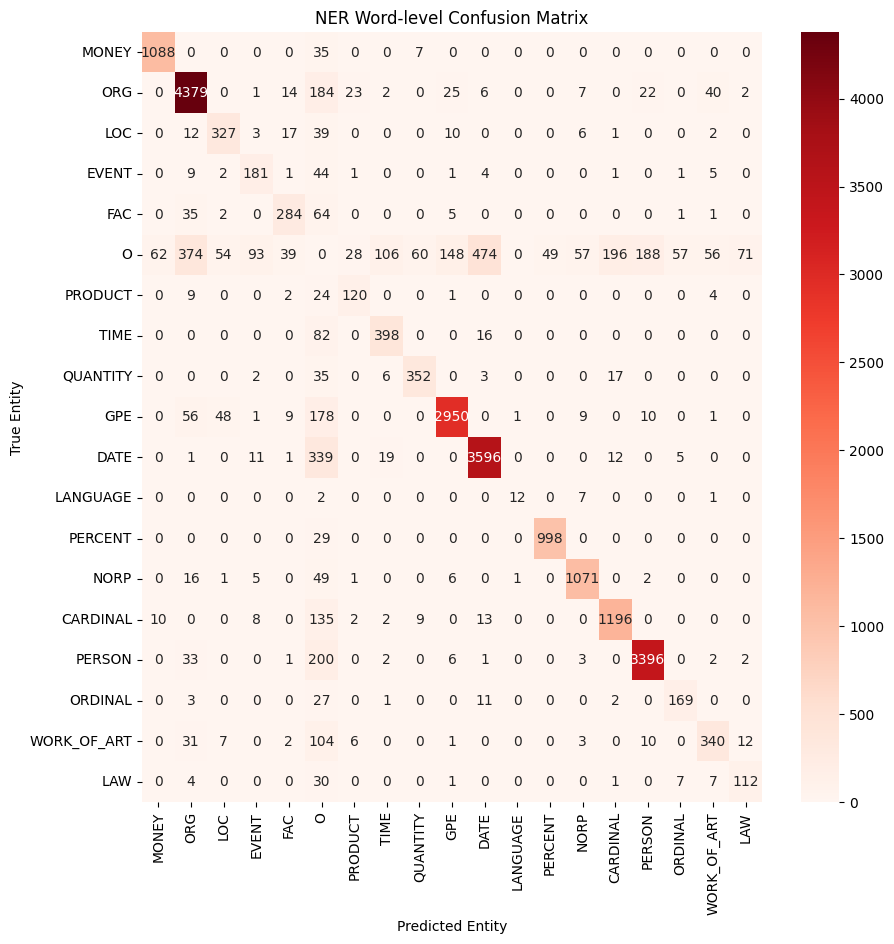

In [45]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id))

Рассмотрев Confusion Matrix мы можем отметить несколько тенденций неудачного расспознования сущностей (при этом занулен счетчик правильных предсказаний `Outside`-`Outside` для более плавной индикации ошибок heatmap'ом):
1. Сущность `Time` часто ошибочно классифицируется как `Outside`; а также логичная ошибка классификации `Time` $\leftrightarrow$ `Date`
2. Помимо упомянутой ошибки, `Date` часто не обнаруживается и ошибочно размечается как `Outside`
3. `Law` часто ошибочно классифицируется как `Outside` и обратно, то есть модель в целом обладает низким пониманием этого класса
4. `Language` часто классифицировался моделью как `Norp`, при этом взаимных ошибок с `Outside` почти нет; семантическая роль `Norp` и `Language` может быть схожа, что объясняет ошибку (также часто токены схожи из-за механизма словообразования английского языка - прим. English может встречаться в контексте национальности или языка), так как очень мала встречаемость класса, модель, скорее всего, не научилась разделять их.
5. Похожая ошибка возникает у сущностей классов `Cardinal` и `Date`, но в процентном соотношении эта доля мала для обоих классов, что дает основания полагать, что проблема исходит из низкого количества сэмплов, так как `Cardinal` и `Date` намного более распространены и модель лучшще научилась их разделять.

Для большей наглоядности заполним диагональ нулями (также для более прозрачной индикации heatmap'ом):

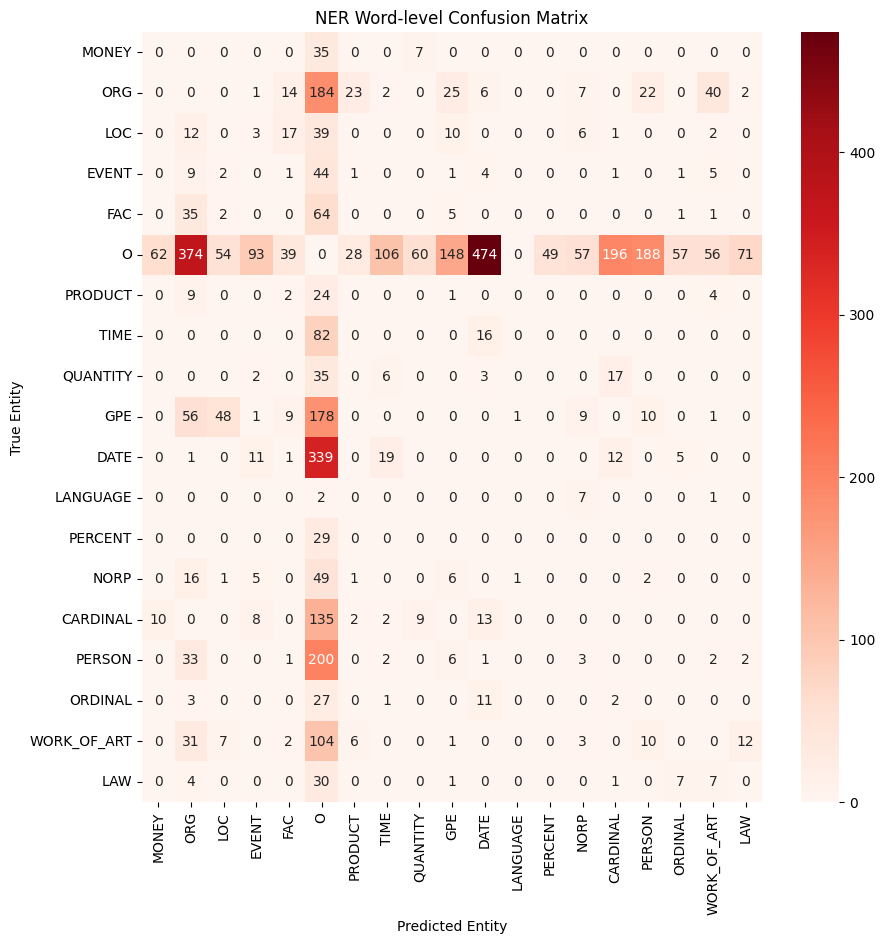

In [46]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id), True)

Если рассматривать ошибки между классами, то наглядно видно, что большая часть приходится на `Outside`-`<ANY ENTITY>`, а так как `Outside` - это "фоновый" класс, можно высказать предположение, что у модели есть общая проблема с детекцией классов, усиливающаяся с редкостью каждого конкретного класса.

Рассмотрим метрики классификации по каждому классу и в обшей совокупности:

In [ ]:
results = metric.compute(predictions=all_preds, references=all_gt)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8383
Recall: 0.8639
F1-Score: 0.8509
Accuracy: 0.9780

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7994
  Recall: 0.8209
  F1-Score: 0.8100

DATE:
  Precision: 0.8023
  Recall: 0.8539
  F1-Score: 0.8273

EVENT:
  Precision: 0.5514
  Recall: 0.6941
  F1-Score: 0.6146

FAC:
  Precision: 0.6014
  Recall: 0.5973
  F1-Score: 0.5993

GPE:
  Precision: 0.9175
  Recall: 0.9002
  F1-Score: 0.9088

LANGUAGE:
  Precision: 0.8571
  Recall: 0.5455
  F1-Score: 0.6667

LAW:
  Precision: 0.5000
  Recall: 0.5909
  F1-Score: 0.5417

LOC:
  Precision: 0.6695
  Recall: 0.7349
  F1-Score: 0.7007

MONEY:
  Precision: 0.8591
  Recall: 0.8930
  F1-Score: 0.8757

NORP:
  Precision: 0.8782
  Recall: 0.9101
  F1-Score: 0.8938

ORDINAL:
  Precision: 0.7042
  Recall: 0.8164
  F1-Score: 0.7562

ORG:
  Precision: 0.8541
  Recall: 0.8916
  F1-Score: 0.8724

PERCENT:
  Precision: 0.8505
  Recall: 0.8922
  F1-Score: 0.8708

PERSON:
  Precision: 0.9030
  Recall: 0.9030
  F1-Score:

Метрики подтверждают ранее сделанные выводы, также можно отметить новые уязвимые места. При этом средние метрики высоки.

In [ ]:
from scipy.stats import spearmanr

counts = []
p_scores = []
r_scores = []
f1_scores = []

for key, cnt in classes_cnt.items():
    if key != "O":
        counts.append(cnt)
        p_scores.append(results[key]["precision"])
        r_scores.append(results[key]["recall"])
        f1_scores.append(results[key]["f1"])

print(
    "Count-Precision Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, p_scores)
    )
)
print(
    "Count-Recall Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, r_scores)
    )
)
print(
    "Count-F1 Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, f1_scores)
    )
)

Count-Precision Spearman correlation: ρ=0.614 with p_val=0.007 
Count-Recall Spearman correlation: ρ=0.806 with p_val=0.000 
Count-F1 Spearman correlation: ρ=0.773 with p_val=0.000 


Корреляции показывают прочную прямую связь возможности обнаружения классов и их частотой в тренировочном наборе.

Возможным вариантом улучшения качества классификации является тренировка со взвешенной функцией потерь.

In [ ]:
all_classes_cnt = {}
for tag_arr in tqdm(tokenized_datasets["train"]["labels"]):
    for cls_num in tag_arr:
        if cls_num != -100:
            cls_name = ENTITY_MAPPING[cls_num]
            if cls_name not in all_classes_cnt:
                all_classes_cnt[cls_name] = 1
            else:
                all_classes_cnt[cls_name] += 1

100%|██████████| 115812/115812 [00:01<00:00, 107633.43it/s]


In [ ]:
class_weights = torch.zeros(len(all_classes_cnt))
for k, v in all_classes_cnt.items():
    class_weights[label2id[k]] = v

In [ ]:
class_weights = 1 / class_weights

In [ ]:
class_weights = class_weights.to("cuda")

In [ ]:
# torch.cuda.set_device(0)

In [ ]:
class TrainerWithWeightedLoss(Trainer):
    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

        active_loss = inputs.get("attention_mask").view(-1) == 1
        # Fix: Get the original model from the DataParallel wrapper
        original_model = model.module if hasattr(model, 'module') else model
        active_logits = logits.view(-1, original_model.config.num_labels)
        active_labels = torch.where(
            active_loss,
            labels.view(-1),
            torch.tensor(loss_fct.ignore_index).type_as(labels),
        )

        loss = loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
weighted_tuning_args = TrainingArguments(
    output_dir="./weight_tuned_ner_model",
    evaluation_strategy="epoch",
    learning_rate=0.5 * LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
weighted_trainer = TrainerWithWeightedLoss(
    model=model,
    args=weighted_tuning_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

/tmp/ipykernel_36/3829986054.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TrainerWithWeightedLoss.__init__`. Use `processing_class` instead.
  weighted_trainer = TrainerWithWeightedLoss(


In [ ]:
weighted_trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.161600,0.707066,0.718894,0.887934,0.794522,0.966387
2,0.070700,0.781287,0.752010,0.895991,0.817711,0.970154
3,0.051700,0.789607,0.749629,0.893633,0.815321,0.969711


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=5430, training_loss=0.10334712954076834, metrics={'train_runtime': 9013.0123, 'train_samples_per_second': 38.548, 'train_steps_per_second': 0.602, 'total_flos': 4.4663646696107736e+16, 'train_loss': 0.10334712954076834, 'epoch': 3.0})

In [ ]:
weighted_trainer.save_model("./ner-5-epochs-tuned-3-epochs")

In [ ]:
# predictions = trainer.predict(tokenized_datasets["test"])
model_path = "/content/drive/MyDrive/model_5_epochs_tuned_3_epochs/model_5_epochs_tuned_3_epochs"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

label_names = ds_test.features["tags"].feature.names

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_label_ids = np.argmax(predictions, axis=-1)

/tmp/ipython-input-1267966716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


In [ ]:
aligned = align_predictions(
    tokenizer,
    dataset["test"],
    tokenized_datasets["test"],
    predictions,
    model.config.id2label,
    max_length=MAX_LENGTH,
)

In [ ]:
all_preds = [list(map(lambda tuple_: tuple_[1], list_)) for list_ in aligned]
all_gt = [list(map(lambda tuple_: tuple_[2], list_)) for list_ in aligned]

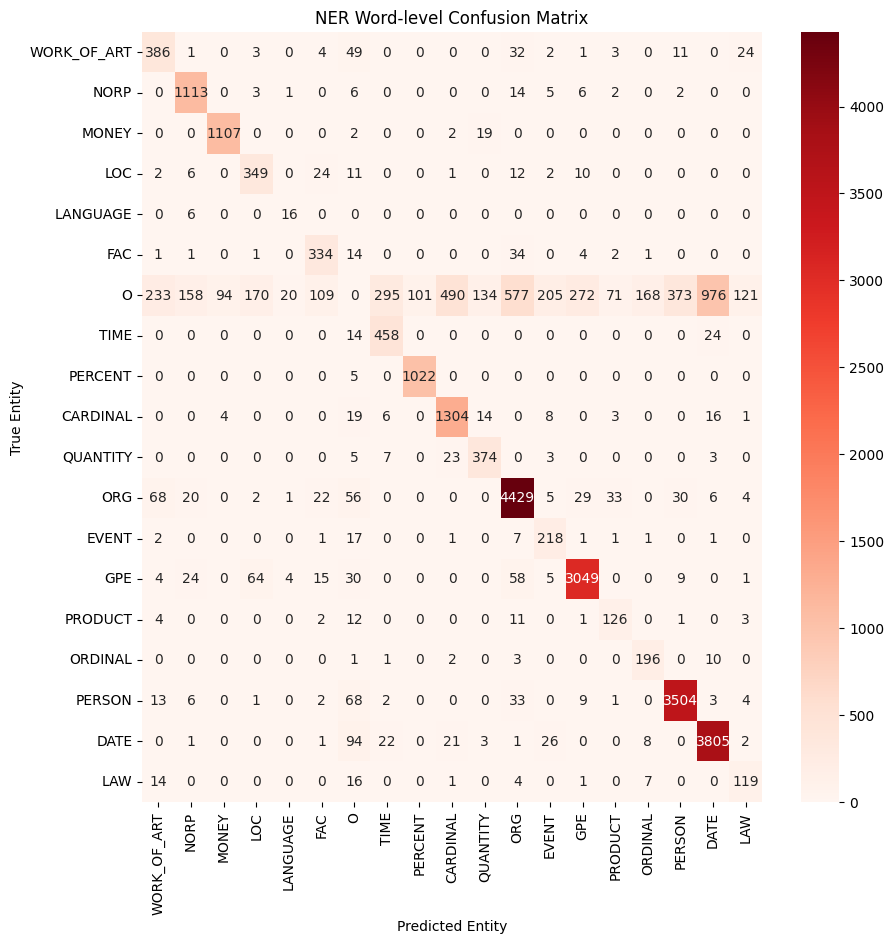

In [ ]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id))

In [ ]:
results = metric.compute(predictions=all_preds, references=all_gt)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.7253
Recall: 0.8900
F1-Score: 0.7993
Accuracy: 0.9712

Detailed Metrics per class:

CARDINAL:
  Precision: 0.6442
  Recall: 0.8756
  F1-Score: 0.7423

DATE:
  Precision: 0.6702
  Recall: 0.8858
  F1-Score: 0.7631

EVENT:
  Precision: 0.3282
  Recall: 0.7529
  F1-Score: 0.4571

FAC:
  Precision: 0.4217
  Recall: 0.6510
  F1-Score: 0.5119

GPE:
  Precision: 0.8831
  Recall: 0.9258
  F1-Score: 0.9039

LANGUAGE:
  Precision: 0.3659
  Recall: 0.6818
  F1-Score: 0.4762

LAW:
  Precision: 0.2917
  Recall: 0.6364
  F1-Score: 0.4000

LOC:
  Precision: 0.4571
  Recall: 0.7674
  F1-Score: 0.5729

MONEY:
  Precision: 0.7597
  Recall: 0.8817
  F1-Score: 0.8162

NORP:
  Precision: 0.7818
  Recall: 0.9374
  F1-Score: 0.8525

ORDINAL:
  Precision: 0.5118
  Recall: 0.9420
  F1-Score: 0.6633

ORG:
  Precision: 0.7923
  Recall: 0.8916
  F1-Score: 0.8390

PERCENT:
  Precision: 0.8190
  Recall: 0.8873
  F1-Score: 0.8518

PERSON:
  Precision: 0.8506
  Recall: 0.9339
  F1-Score:

In [ ]:
from scipy.stats import spearmanr

counts = []
p_scores = []
r_scores = []
f1_scores = []

for key, cnt in classes_cnt.items():
    if key != "O":
        counts.append(cnt)
        p_scores.append(results[key]["precision"])
        r_scores.append(results[key]["recall"])
        f1_scores.append(results[key]["f1"])

print(
    "Count-Precision Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, p_scores)
    )
)
print(
    "Count-Recall Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, r_scores)
    )
)
print(
    "Count-F1 Spearman correlation: ρ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, f1_scores)
    )
)

Count-Precision Spearman correlation: ρ=0.775 with p_val=0.000 
Count-Recall Spearman correlation: ρ=0.595 with p_val=0.009 
Count-F1 Spearman correlation: ρ=0.754 with p_val=0.000 


In [ ]:
class_weights = torch.zeros(len(all_classes_cnt))
for k, v in all_classes_cnt.items():
    class_weights[label2id[k]] = v

In [ ]:
soft_weights = torch.nn.functional.softmax((1/class_weights) / 0.25, dim=0)

In [ ]:
class_weights

tensor([1.9612e+06, 1.0901e+04, 1.8791e+04, 1.0090e+03, 1.1580e+03, 2.1938e+04,
        3.5500e+02, 4.5900e+02, 2.1600e+03, 5.2170e+03, 9.3410e+03, 2.1950e+03,
        2.4163e+04, 3.8020e+03, 2.2035e+04, 9.9200e+02, 1.2400e+03, 1.7030e+03,
        1.2790e+03, 3.5290e+03, 2.2407e+04, 2.0870e+03, 1.9310e+03, 5.4160e+03,
        1.7000e+01, 1.1980e+03, 1.9830e+03, 9.9870e+03, 6.1500e+02, 2.0000e+01,
        3.2791e+04, 5.4240e+03, 1.5358e+04, 8.2000e+02, 1.9330e+03, 2.1290e+03,
        3.2340e+03])

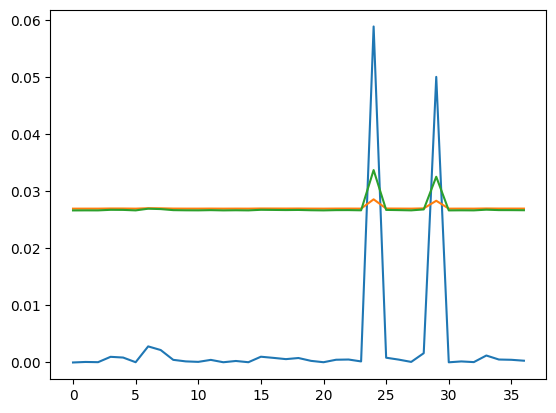

In [ ]:
plt.plot(1/class_weights)
plt.plot(torch.nn.functional.softmax((1/class_weights), dim=0))
plt.plot(soft_weights)

In [ ]:
class TrainerWithSofWeightedLoss(Trainer):
    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=soft_weights.to("cuda"))

        active_loss = inputs.get("attention_mask").view(-1) == 1
        # Fix: Get the original model from the DataParallel wrapper
        original_model = model.module if hasattr(model, 'module') else model
        active_logits = logits.view(-1, original_model.config.num_labels)
        active_labels = torch.where(
            active_loss,
            labels.view(-1),
            torch.tensor(loss_fct.ignore_index).type_as(labels),
        )

        loss = loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
model_path = "./ner-final-model-5-epochs"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

label_names = ds_test.features["tags"].feature.names

In [ ]:
weighted_tuning_args = TrainingArguments(
    output_dir="./soft_weight_tuned_ner_model",
    evaluation_strategy="epoch",
    learning_rate=0.5 * LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
weighted_trainer = TrainerWithSofWeightedLoss(
    model=model,
    args=weighted_tuning_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

/tmp/ipykernel_36/1817443323.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TrainerWithSofWeightedLoss.__init__`. Use `processing_class` instead.
  weighted_trainer = TrainerWithSofWeightedLoss(


In [ ]:
weighted_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.019700,0.086769,0.844096,0.891373,0.867090,0.978546
2,0.013900,0.094027,0.853862,0.885870,0.869572,0.978933
3,0.010200,0.097449,0.854268,0.884445,0.869095,0.978825


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=5430, training_loss=0.01507332821138217, metrics={'train_runtime': 8581.0202, 'train_samples_per_second': 40.489, 'train_steps_per_second': 0.633, 'total_flos': 4.4663646696107736e+16, 'train_loss': 0.01507332821138217, 'epoch': 3.0})

In [ ]:
weighted_trainer.save_model("./ner-5-epochs-tuned-soft-weight-3-epochs")

In [47]:
# predictions = trainer.predict(tokenized_datasets["test"])
model_path = "/content/drive/MyDrive/model_soft_weight_finetune"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

label_names = ds_test.features["tags"].feature.names

In [48]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_label_ids = np.argmax(predictions, axis=-1)

/tmp/ipython-input-1267966716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:
aligned = align_predictions(
    tokenizer,
    dataset["test"],
    tokenized_datasets["test"],
    predictions,
    model.config.id2label,
    max_length=MAX_LENGTH,
)

In [50]:
all_preds = [list(map(lambda tuple_: tuple_[1], list_)) for list_ in aligned]
all_gt = [list(map(lambda tuple_: tuple_[2], list_)) for list_ in aligned]

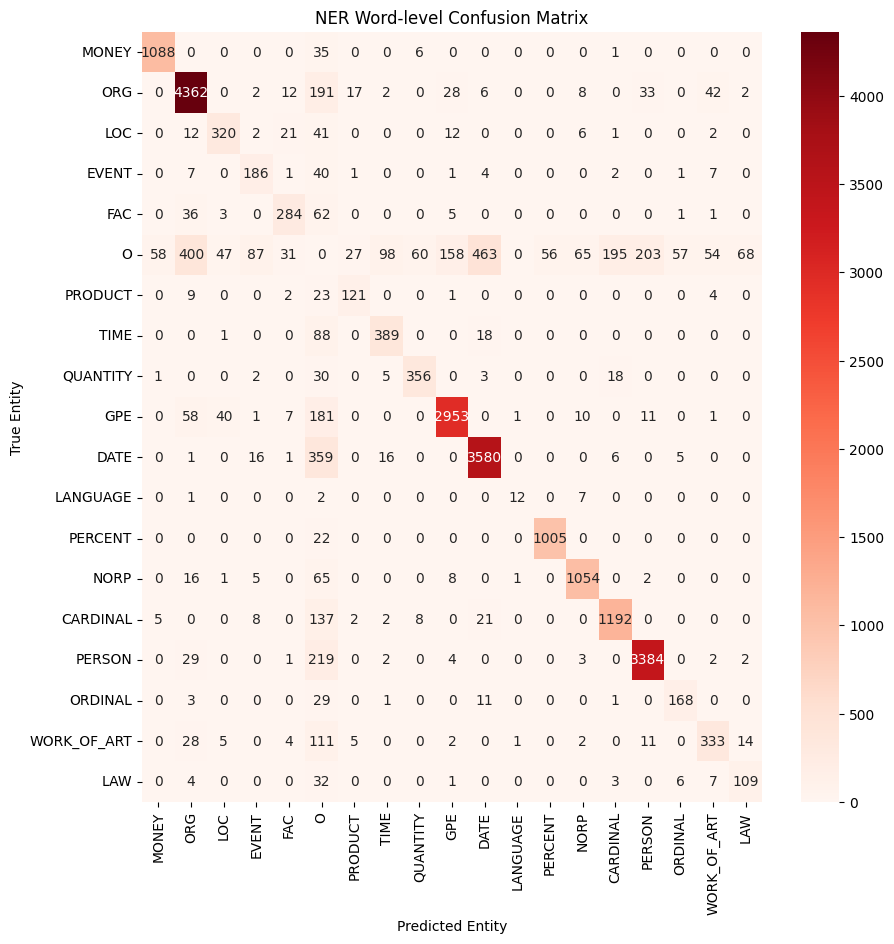

In [51]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id))

In [52]:
results = metric.compute(predictions=all_preds, references=all_gt)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8334
Recall: 0.8630
F1-Score: 0.8480
Accuracy: 0.9775

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7897
  Recall: 0.8219
  F1-Score: 0.8055

DATE:
  Precision: 0.8045
  Recall: 0.8523
  F1-Score: 0.8277

EVENT:
  Precision: 0.5273
  Recall: 0.6824
  F1-Score: 0.5949

FAC:
  Precision: 0.6242
  Recall: 0.6242
  F1-Score: 0.6242

GPE:
  Precision: 0.9151
  Recall: 0.9018
  F1-Score: 0.9084

LANGUAGE:
  Precision: 0.8000
  Recall: 0.5455
  F1-Score: 0.6486

LAW:
  Precision: 0.4630
  Recall: 0.5682
  F1-Score: 0.5102

LOC:
  Precision: 0.6739
  Recall: 0.7209
  F1-Score: 0.6966

MONEY:
  Precision: 0.8468
  Recall: 0.8873
  F1-Score: 0.8666

NORP:
  Precision: 0.8511
  Recall: 0.8949
  F1-Score: 0.8725

ORDINAL:
  Precision: 0.7017
  Recall: 0.8068
  F1-Score: 0.7506

ORG:
  Precision: 0.8462
  Recall: 0.8931
  F1-Score: 0.8690

PERCENT:
  Precision: 0.8618
  Recall: 0.9167
  F1-Score: 0.8884

PERSON:
  Precision: 0.8972
  Recall: 0.9039
  F1-Score: